In [ ]:
import os
import math
import random
import pickle
import xml.etree.ElementTree as ET
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
from torch import FloatTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, sampler
import torchvision
from torchvision import models, datasets
from sklearn.metrics import classification_report, confusion_matrix, f1_score


In [ ]:
crda = os.path.join("/content/drive/MyDrive/vision/project2/carsdata", 'cropped_data')
all_data = datasets.ImageFolder(root=crda)

Analyzing and Plotting the Number of Images per Class

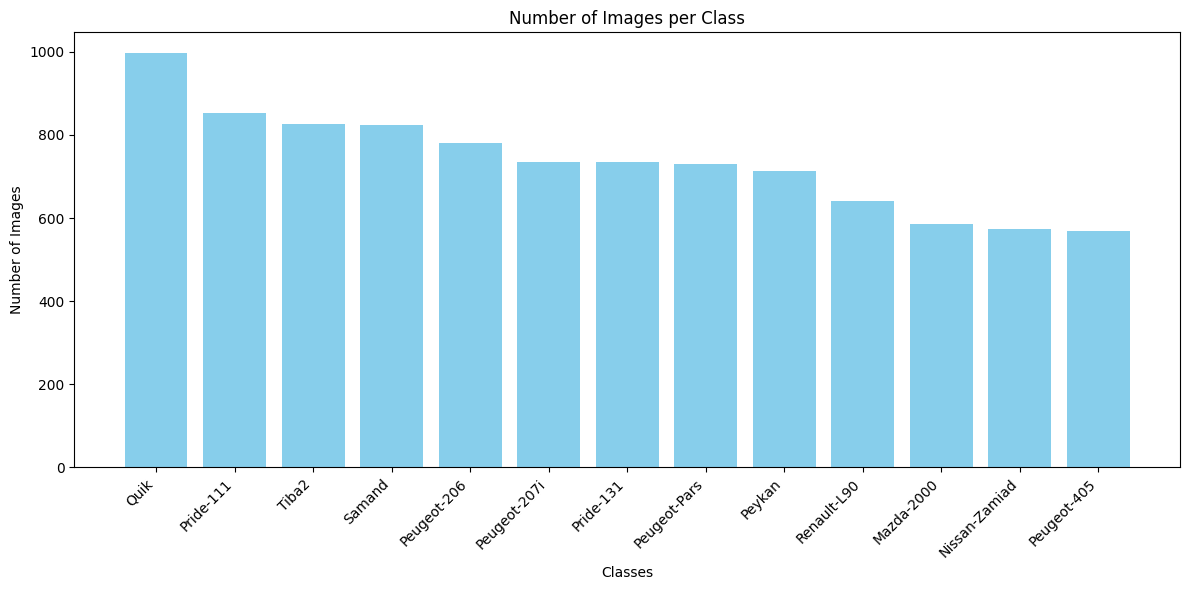

In [ ]:
# Dictionary to store the number of images per class
class_counts = {}

# Iterate over classes
for class_name in os.listdir(crda):
    class_folder = os.path.join(crda, class_name)
    if os.path.isdir(class_folder):
        num_images = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = num_images

# Sort classes based on the number of images
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Images per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


In [ ]:
class_counts

{'Mazda-2000': 585,
 'Nissan-Zamiad': 573,
 'Peugeot-206': 781,
 'Peugeot-207i': 735,
 'Peugeot-405': 569,
 'Peugeot-Pars': 730,
 'Peykan': 714,
 'Pride-111': 853,
 'Pride-131': 734,
 'Quik': 997,
 'Renault-L90': 642,
 'Samand': 825,
 'Tiba2': 826}

Data Loading

In [ ]:
# Data Augmentation
batch_size = 128
image_size = 640

image_transforms = {

    'train':torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=(640,640)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
    ]),
    'val':torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=(640,640)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
        ])
}

In [ ]:
train_data_len = int(len(all_data) * 0.95)
valid_data_len = int((len(all_data) - train_data_len) / 2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)

train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])

train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['val']
test_data.dataset.transform = image_transforms['val']

print(len(train_data), len(val_data), len(test_data))

9085 239 240


In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([128, 3, 640, 640]) torch.Size([128])


Model Architecture: ResNet-50 with Self-Attention Layer

In [ ]:
def new_parameter(*size):
    out = nn.Parameter(torch.empty(*size), requires_grad=True)
    torch.nn.init.xavier_normal_(out)
    return out


class Attention(nn.Module):

    def __init__(self, attention_size):
        super(Attention, self).__init__()
        self.attention = new_parameter(attention_size, 1)

    def forward(self, x_in):
        device = x_in.device
        attention = self.attention.to(device)

        attention_score = torch.matmul(x_in, attention).squeeze()
        attention_score = F.softmax(attention_score, dim=-1).view(x_in.size(0), x_in.size(1), 1)
        scored_x = x_in * attention_score

        condensed_x = torch.sum(scored_x, dim=1)

        return condensed_x

In [ ]:
features = 2048
fmap_size = 20

class CNN_Resnet_Attention(nn.Module):
    def __init__(self, fine_tune=False):
        super(CNN_Resnet_Attention, self).__init__()

        resnet = models.resnet50(pretrained=True)

        if not fine_tune:
            for param in resnet.parameters():
                param.requires_grad = False
        else:
            for param in resnet.parameters():
                param.requires_grad = True

        layers = list(resnet.children())[:-2]

        self.features = nn.Sequential(*layers).cuda() if torch.cuda.is_available() else nn.Sequential(*layers)
        if not torch.cuda.is_available():
            print("CUDA is not available. Model will run on CPU.")

        self.attn = Attention(features)  # Attention(2048)
        self.fc = nn.Linear(features, 13)
        self.dropout = nn.Dropout(0.2)

        # FC layer init
        nn.init.xavier_normal_(self.fc.weight.data)
        if self.fc.bias is not None:
            torch.nn.init.constant_(self.fc.bias.data, val=0)

    def forward(self, x):
        N = x.size(0)
        x = self.features(x)
        x = x.view(N, features, fmap_size ** 2)
        x = torch.bmm(x, torch.transpose(x, 1, 2)) / (fmap_size ** 2)
        x = torch.sqrt(x + 1e-5)
        x = self.attn(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Resnet_Attention()
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model.parameters(), lr=0.001)


Training

In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          val_loader,
          save_location,
          early_stop=5,
          n_epochs=70,
          print_every=1):

    #Initializing some variables
    valid_loss_min = np.inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0
    best_model_path = None

    #Loop starts here
    for epoch in range(n_epochs):

        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()

        ### batch control
        ii = 0

        for data, label in train_loader:

            ii += 1

            # Use CUDA if available, otherwise use CPU
            if torch.cuda.is_available():
                data, label = data.cuda(), label.cuda()
            else:
                print("CUDA is not available. Training on CPU.")

            output = model(data)

            loss = criterion(output, label)
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            #More detailed logging per batch
            print(f'[Epoch {epoch} | Batch {ii}/{len(train_loader)}] Loss: {loss.item():.4f} | Acc: {accuracy.item() * 100:.2f}%')

        model.epochs += 1

        with torch.no_grad():

            model.eval()

            for data, label in val_loader:

                if torch.cuda.is_available():
                    data, label = data.cuda(), label.cuda()

                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])
            with open(os.path.join(save_location, 'history.pkl') , 'wb') as f :
              pickle.dump(history,f)

            if (epoch + 1) % print_every == 0:

                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_acc > valid_max_acc:

                model_path = os.path.join(save_location, f'rn50_epoch_{epoch+1:03d}_acc_{valid_acc*100:.2f}.pt')
                torch.save({
                    'epoch': epoch+1,
                    'state_dict': model.state_dict(),
                    'valid_loss': valid_loss,
                    'valid_acc': valid_acc
                }, model_path)

                valid_loss_min = valid_loss
                valid_max_acc = valid_acc
                best_model_path = model_path
                stop_count = 0
                best_epoch = epoch

            else:

                stop_count += 1

                if stop_count >= early_stop:

                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    if best_model_path:
                        model.load_state_dict(torch.load(best_model_path)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history

    model.optimizer = optimizer
    if best_model_path:
        model.load_state_dict(torch.load(best_model_path)['state_dict'])
    print(f'\nTraining complete. Best epoch: {best_epoch} with acc: {valid_max_acc*100:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

    return model, history

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer1,
    train_loader,
    val_loader,
    save_location='/content/drive/MyDrive/vision/project2/model',
    early_stop=10,
    n_epochs=30,
    print_every=1)

[Epoch 0 | Batch 1/71] Loss: 2.9810 | Acc: 7.81%
[Epoch 0 | Batch 2/71] Loss: 2.6765 | Acc: 9.38%
[Epoch 0 | Batch 3/71] Loss: 2.7578 | Acc: 7.81%
[Epoch 0 | Batch 4/71] Loss: 2.6599 | Acc: 12.50%
[Epoch 0 | Batch 5/71] Loss: 2.7508 | Acc: 6.25%
[Epoch 0 | Batch 6/71] Loss: 2.7022 | Acc: 8.59%
[Epoch 0 | Batch 7/71] Loss: 2.8002 | Acc: 7.03%
[Epoch 0 | Batch 8/71] Loss: 2.6685 | Acc: 14.84%
[Epoch 0 | Batch 9/71] Loss: 2.7218 | Acc: 8.59%
[Epoch 0 | Batch 10/71] Loss: 2.7925 | Acc: 4.69%
[Epoch 0 | Batch 11/71] Loss: 2.6161 | Acc: 10.16%
[Epoch 0 | Batch 12/71] Loss: 2.5982 | Acc: 5.47%
[Epoch 0 | Batch 13/71] Loss: 2.6126 | Acc: 9.38%
[Epoch 0 | Batch 14/71] Loss: 2.6880 | Acc: 7.81%
[Epoch 0 | Batch 15/71] Loss: 2.5870 | Acc: 9.38%
[Epoch 0 | Batch 16/71] Loss: 2.5752 | Acc: 10.16%
[Epoch 0 | Batch 17/71] Loss: 2.5770 | Acc: 13.28%
[Epoch 0 | Batch 18/71] Loss: 2.5830 | Acc: 6.25%
[Epoch 0 | Batch 19/71] Loss: 2.5147 | Acc: 12.50%
[Epoch 0 | Batch 20/71] Loss: 2.5271 | Acc: 10.16%
[E

Training and Validation Performance Visualization

In [ ]:
with open ('/content/drive/MyDrive/vision/project2/model/history.pkl' , 'rb') as f :
  history =pickle.load(f)

history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

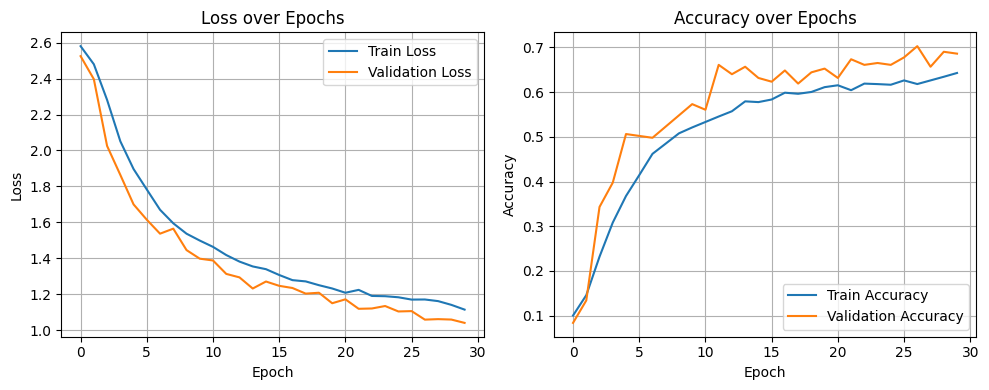

In [ ]:
# Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['valid_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Final Evaluation

In [ ]:
model_path = '/content/drive/MyDrive/vision/project2/model/rn50_epoch_027_acc_70.29.pt'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

===== Classification Report =====
               precision    recall  f1-score   support

   Mazda-2000       0.75      0.90      0.82        20
Nissan-Zamiad       0.95      1.00      0.97        19
  Peugeot-206       0.63      0.80      0.71        15
 Peugeot-207i       0.62      0.87      0.72        15
  Peugeot-405       0.89      0.62      0.73        13
 Peugeot-Pars       0.85      0.73      0.79        15
       Peykan       0.80      0.62      0.70        13
    Pride-111       0.62      0.53      0.57        15
    Pride-131       0.73      0.79      0.76        24
         Quik       0.74      0.87      0.80        30
  Renault-L90       0.77      0.53      0.62        19
       Samand       1.00      0.76      0.86        21
        Tiba2       0.81      0.81      0.81        21

     accuracy                           0.77       240
    macro avg       0.78      0.76      0.76       240
 weighted avg       0.78      0.77      0.77       240

===== Accuracy Scores =====


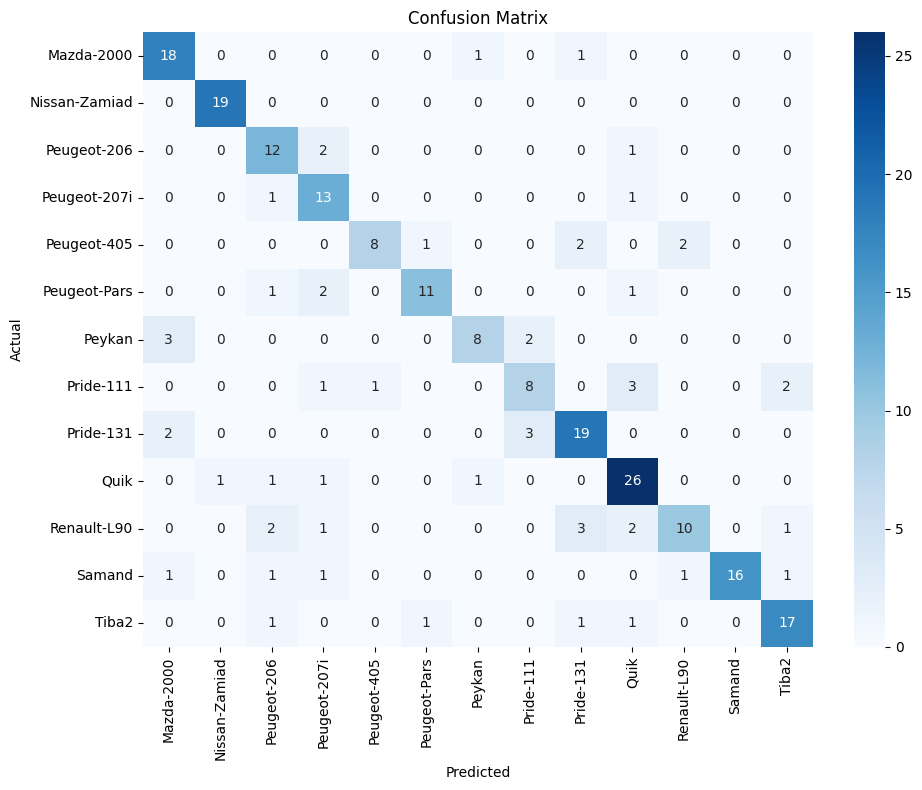

In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

y_true = []
y_pred = []

top1_correct = 0
top5_correct = 0
total = 0

input_images = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        # Top-1
        _, preds = torch.max(outputs, 1)
        top1_correct += (preds == labels).sum().item()

        # Top-5
        _, top5 = outputs.topk(5, dim=1)
        top5_correct += torch.sum(top5.eq(labels.view(-1, 1))).item()

        input_images.extend(inputs.cpu())

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        total += labels.size(0)

top1_acc = top1_correct / total
top5_acc = top5_correct / total

class_names = all_data.classes

print("===== Classification Report =====")
print(classification_report(y_true, y_pred, target_names=class_names))

print("===== Accuracy Scores =====")
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


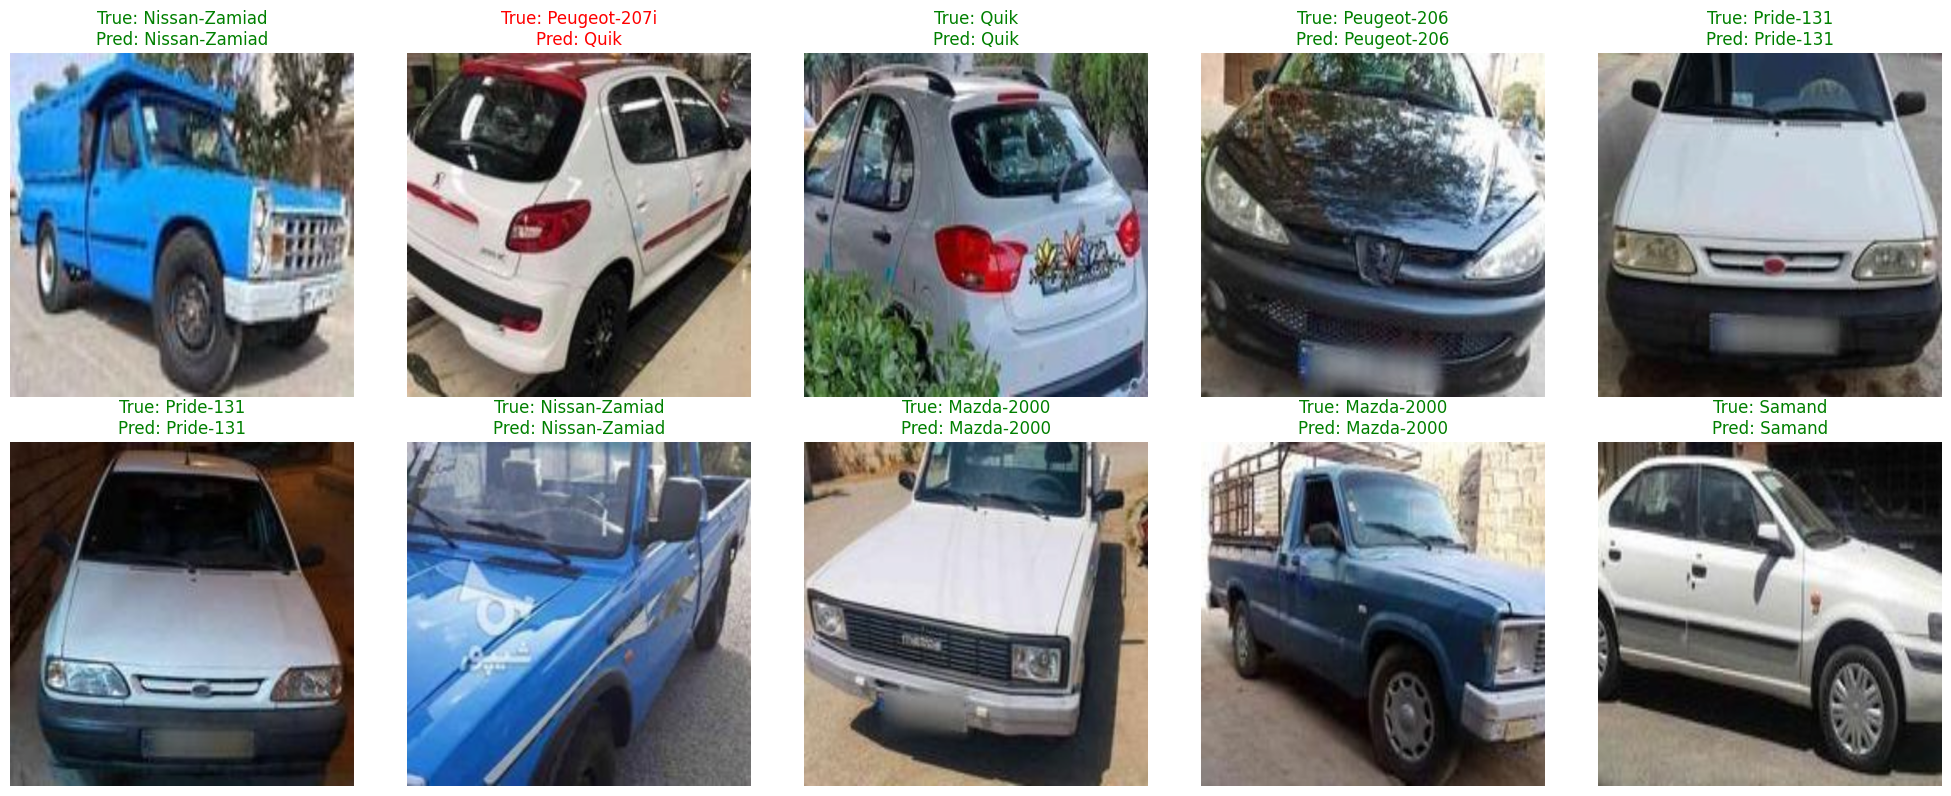

In [ ]:
plt.figure(figsize=(20, 8))
num_images = len(input_images)
random_indices = random.sample(range(num_images), 10)

for i, idx in enumerate(random_indices):
    img = input_images[idx].permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)

    is_correct = y_pred[idx] == y_true[idx]
    title_color = 'green' if is_correct else 'red'

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()
